In [2]:
import yfinance as yf
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from curl_cffi import requests
session = requests.Session(impersonate="chrome")
aapl = yf.Ticker('AAPL', session=session)

In [4]:
df = yf.download('AAPL', start='2010-01-01', end='2023-10-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


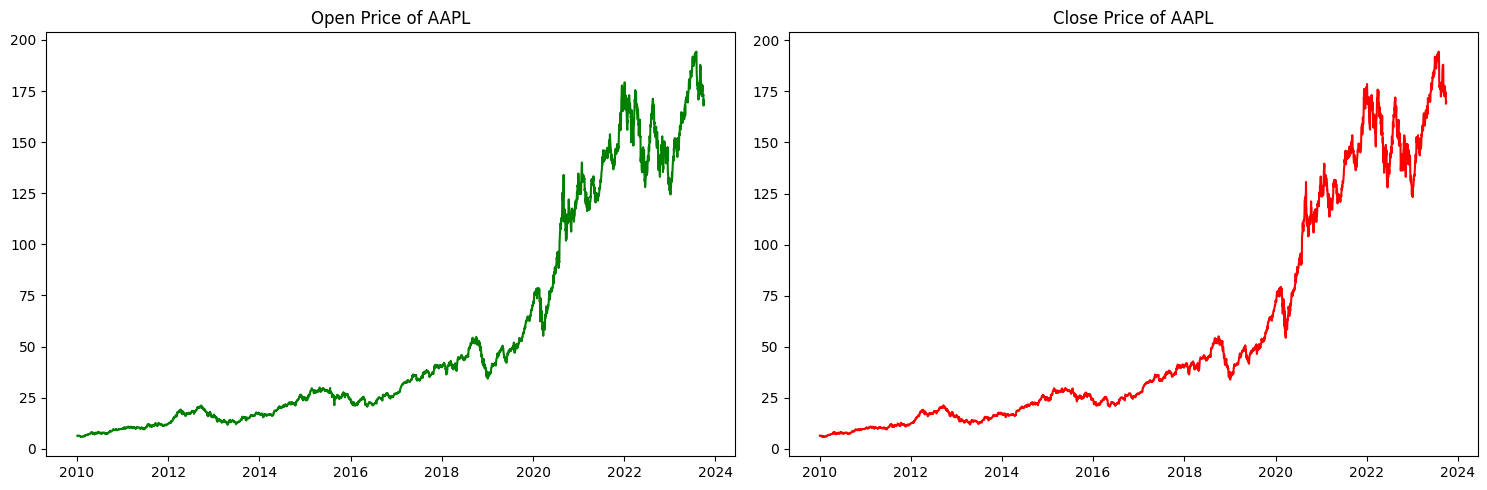

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(df["Open"], label='Open', color="green")
ax[0].set_title("Open Price of AAPL")

ax[1].plot(df["Close"], label='Close', color="red")
ax[1].set_title("Close Price of AAPL")

plt.tight_layout()  # Adjust spacing between plots
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler()

train_df, test_df = train_test_split(df, test_size=0.1, shuffle=False)

In [7]:
#create a sliding window 
train = train_df["Close"].values
test = test_df["Close"].values

train = scaler.fit_transform(train)
test = scaler.transform(test)

X_train, y_train = [], []
for i in range(60, len(train)):
    X_train.append(train[i-60:i, 0])
    y_train.append(train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
from tensorflow import keras

model = keras.models.Sequential()

model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64, return_sequences=False))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1))

model.summary()
model.compile(optimizer='adam', loss='mae', metrics=["root_mean_squared_error"], learning_rate=1e-4)

c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0525 - root_mean_squared_error: 0.0882 - val_loss: 0.0269 - val_root_mean_squared_error: 0.0339
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0224 - root_mean_squared_error: 0.0384 - val_loss: 0.0612 - val_root_mean_squared_error: 0.0692
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0186 - root_mean_squared_error: 0.0346 - val_loss: 0.0342 - val_root_mean_squared_error: 0.0429
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0183 - root_mean_squared_error: 0.0306 - val_loss: 0.0559 - val_root_mean_squared_error: 0.0636
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0160 - root_mean_squared_error: 0.0287 - val_loss: 0.0876 - val_root_mean_squared_error: 0.0930
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0164 - root_mean_squared_error: 0.0293 - val_loss: 0.0339 - val_root_mean_squared_error: 0.0417
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss:

In [12]:
model.save_weights("lstm_aapl_20.weights.h5")

In [14]:
model.load_weights("lstm_aapl_20.weights.h5")

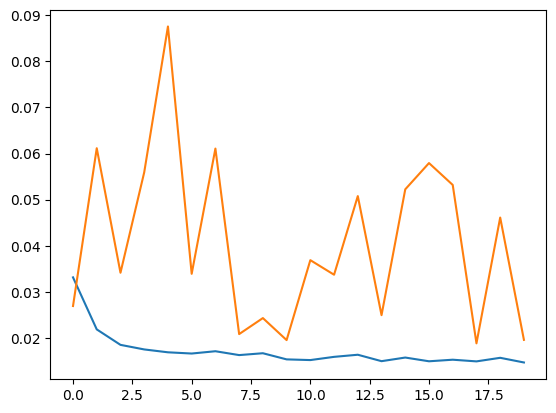

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [16]:
X_test, y_test = [], []
for i in range(60, len(test)):
    X_test.append(test[i-60:i, 0])
    y_test.append(test[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [17]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [23]:
pred = pd.Series(predictions.flatten(), index=test_df.index[60:])

In [25]:
len(test_df)

346

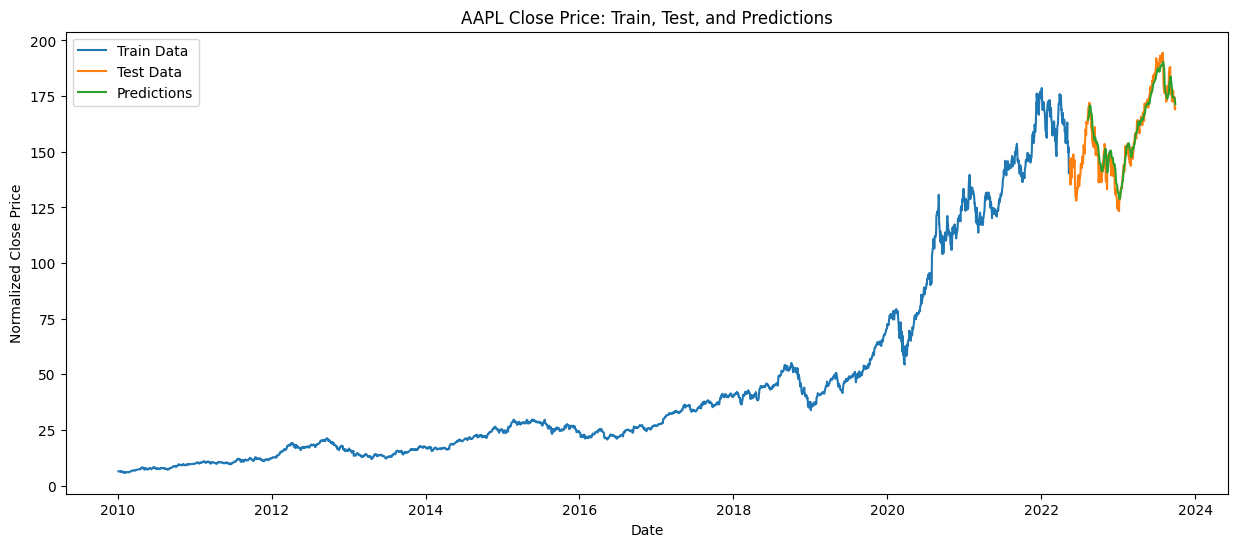

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(train_df.index, train_df[("Close", "AAPL")], label="Train Data")
plt.plot(test_df.index, test_df[("Close", "AAPL")], label="Test Data")
plt.plot(pred.index, pred.values, label="Predictions")
plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.title("AAPL Close Price: Train, Test, and Predictions")
plt.legend()
plt.show()

## forecasting the future

In [31]:
future_steps = 60
future_preds = []

# Start with the last sequence from your test set
last_sequence = X_test[-1:].copy()

for _ in range(future_steps):
    next_pred = model.predict(last_sequence, verbose=0)
    future_preds.append(next_pred[0, 0])
    # Update last_sequence: remove first value, append new prediction
    last_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred.reshape(1, 1, 1)], axis=1)

# Inverse transform to get actual price values
future_preds_actual = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()


In [35]:
#improved version with probabilistic forecasting
def forecast_stocks(model, last_sequence, steps=60, n_samples=10):
    """Probabilistic forecasting with Monte Carlo sampling"""
    predictions = []
    for _ in range(n_samples):
        seq = last_sequence.copy()
        preds = []
        for _ in range(steps):
            # Enable dropout at test time
            next_pred = model.predict(seq, verbose=0) * (1 + np.random.normal(0, 0.01))
            preds.append(next_pred[0, 0])
            seq = np.concatenate([seq[:, 1:, :], 
                                 next_pred.reshape(1, 1, 1)], axis=1)
        predictions.append(preds)
    
    predictions = np.array(predictions)
    future_preds_actual = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    return future_preds_actual

future_preds_actual = forecast_stocks(model, X_test[-1:], steps=100, n_samples=10)

In [40]:
future_preds_actual = future_preds_actual[:100]

In [42]:
future_steps = 100

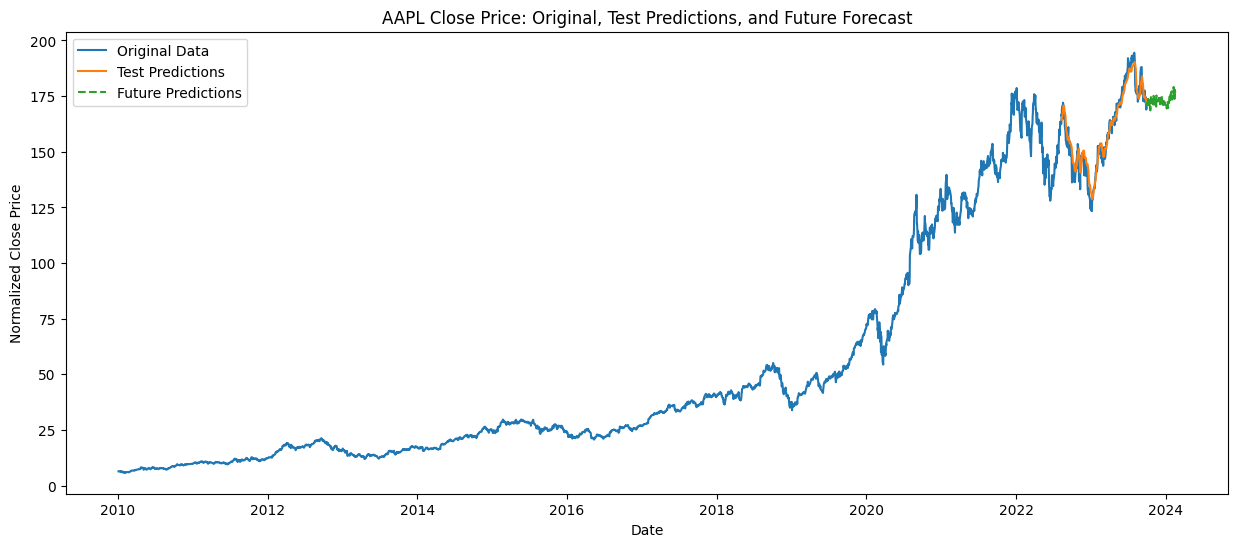

In [43]:
plt.figure(figsize=(15, 6))
# Plot original Close prices
plt.plot(df.index, df[("Close", "AAPL")], label="Original Data")
# Plot predictions on test set
plt.plot(pred.index, pred.values, label="Test Predictions")
# Plot future predictions
future_index = pd.date_range(start=test_df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')
plt.plot(future_index, future_preds_actual, label="Future Predictions", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.title("AAPL Close Price: Original, Test Predictions, and Future Forecast")
plt.legend()
plt.show()

In [46]:
future_df = yf.download("AAPL", start=future_index[0], end=future_index[-1])

[*********************100%***********************]  1 of 1 completed


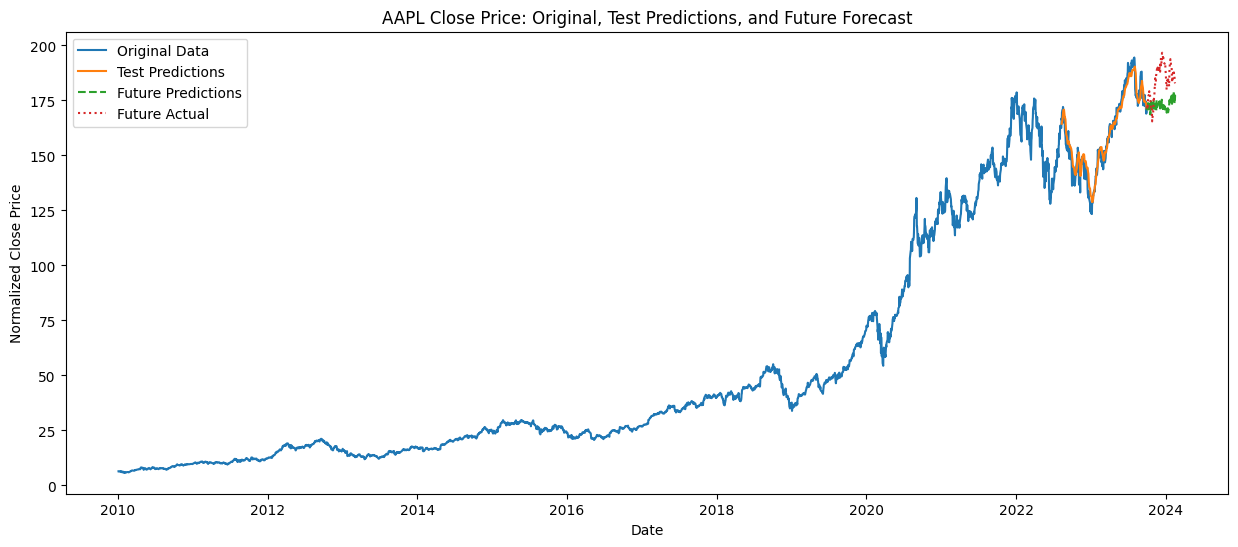

In [47]:
plt.figure(figsize=(15, 6))
# Plot original Close prices
plt.plot(df.index, df[("Close", "AAPL")], label="Original Data")
# Plot predictions on test set
plt.plot(pred.index, pred.values, label="Test Predictions")
# Plot future predictions
future_index = pd.date_range(start=test_df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')
plt.plot(future_index, future_preds_actual, label="Future Predictions", linestyle='--')

plt.plot(future_df.index, future_df[("Close", "AAPL")], label="Future Actual", linestyle=':')

plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.title("AAPL Close Price: Original, Test Predictions, and Future Forecast")
plt.legend()
plt.show()